In [10]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc, precision_score
import scipy.stats

import seaborn as sns
from MutBkgd import MutationBackground

%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})

In [11]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999; 

<IPython.core.display.Javascript object>

In [22]:
prefix = 'HIS.'

s_het = np.load('../data/gene/s_het.npy').item()
prec = np.load('../data/gene/prec.npy').item()
pli = np.load('../data/gene/pli.npy').item()
lofz = np.load('../data/gene/lofz.npy').item()

HS_gene = set(gene for gene, pli_score in pli.iteritems() if pli_score < 0.5)
HIS_gene = set(gene for gene, pli_score in pli.iteritems() if pli_score >= 0.5)
prec_5 = set(gene for gene, pli_score in prec.iteritems() if pli_score >0.5)
lofz3 = set(gene for gene, score in lofz.iteritems() if score >= 3)

if prefix == 'HIS.':
    geneset = HIS_gene 
elif prefix == 'HS.':
    geneset = HS_gene
else:
    geneset = geneset

# compare confusion matrix

In [23]:
def plot_multi_confusion_matrix(df, y_true, dataset, save=False,
                                class_names = ['damage_negative', 'damage_positive']):
    '''take a dataframe with predictors and y_true value, output multiple confusion matrix plot
    '''
    
    # 'M-CAP_rankscore', 0.4815 is 0.025 cutoff 0.642 is 0.05 cutoff
    col_dict={'cadd15':('CADD_phred', 15), 'cadd20':('CADD_phred', 20),
              'cadd25':('CADD_phred', 25), 'cadd30':('CADD_phred', 30),
              'eigen_pred10':('Eigen-phred', 10), 'eigen_pred15':('Eigen-phred', 15),
              'eigen_pc_pred10':('Eigen-PC-phred', 10), 
              'MetaSVM>0':('MetaSVM_rankscore', 0.82271),'MetaLR>0':('MetaLR_rankscore', 0.81122), 
              'M_CAP>0.025':('M-CAP_rankscore', 0.4815), 'M_CAP>0.05':('M-CAP_rankscore', 0.642), 
              'PP2-HVAR':('Polyphen2_HVAR_rankscore', 0.6280),'FATHMM':('FATHMM_converted_rankscore', 0.8235),
              'all_missense':('cnn_prob', 0.0),'cnn_0.05':('cnn_prob', 0.05),
              'cnn_0.1':('cnn_prob', 0.1), 'cnn_0.2':('cnn_prob', 0.2),
              'cnn_0.3':('cnn_prob', 0.3), 'cnn_0.4':('cnn_prob', 0.4),
              'cnn_0.5':('cnn_prob', 0.5), 'cnn_0.6':('cnn_prob', 0.6),
              'cnn_0.7':('cnn_prob', 0.7), 'cnn_0.8':('cnn_prob', 0.8),
              'cnn_best_0.56':('cnn_prob', 0.56)}
    
    y_preds, y_algos = [], []
    for key, (col, threshold) in col_dict.items():
        y_algos.append(key)
        y_preds.append(convert2binary(df, col, threshold))

    infos = []
    for y_pred, y_algo in zip(y_preds, y_algos):
        # Compute confusion matrix
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        cnf_matrix = confusion_matrix(y_true, y_pred)
        fdr = 1 - precision_score(y_true, y_pred)
        np.set_printoptions(precision=2)

        title = '../figure/' + dataset + y_algo + '.png'
        # Plot non-normalized confusion matrix
        figure_title = 'Confusion matrix, without normalization\n{}\n{}\n accuracy: {:.2f}\n f1: {:.2f}\n'.format(
            dataset, y_algo, accuracy, f1)
        fig = plt.figure(figsize = (5,5))
        plot_confusion_matrix(cnf_matrix, classes=class_names,
                              title=figure_title)
        
        if save:
            infos.append([y_algo, accuracy, f1, fdr])
            fig.savefig(title)
            plt.close()
        else:
            plt.show()
    labels = ['Col', 'accuracy', 'f1', 'FDR']            
    df = pd.DataFrame(infos,columns=labels)
    display(df)

def convert2binary(df, col, threshold):
    '''take a dataframe, col to compare, threshold, return the binary vector
        convert to more elegent lambda function way 
        http://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
    '''
    values = np.array(df[col].values)
    index = values >= threshold
    values[index] = 1
    values[~index] = 0
    return values

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes, rotation=45)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
class_names = ['damage_negative', 'damage_positive'] # 0 for 'damage_negative', 1 for 'damage_positive'

validation = '../data/output/output_data_mode5.csv'
fname = validation
df = pd.read_csv(fname)
df = df[df.training==0]
y_true = df.pop('target')
dataset = 'validation(20% HGMD,DiscovEHR)'
plot_multi_confusion_matrix(df, y_true, dataset, save=True)

/home/local/ARCS/hq2130/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (58,62,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Col,accuracy,f1,FDR
0,all_missense,0.501803,0.668267,0.498197
1,PP2-HVAR,0.742640,0.708286,0.178731
2,cnn_0.7,0.942219,0.942536,0.059245
3,eigen_pred10,0.630583,0.442665,0.088930
4,FATHMM,0.782696,0.759156,0.144786
5,cnn_0.05,0.874825,0.888572,0.197036
6,cadd20,0.823353,0.838845,0.226453
7,cnn_0.6,0.942219,0.943348,0.071511
8,cnn_0.5,0.941017,0.942799,0.081725
9,cnn_0.4,0.938013,0.940521,0.093032


In [18]:
fnames = ['../data/metaSVM/metaSVM_test1.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_test2.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest1.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest2.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_train.anno.rare.'+prefix+'reformat.cnn.csv']

for fname in fnames:
    df = pd.read_csv(fname)
    y_true = df.pop('target')
    dataset = fname.split('_')[-1].split('.')[0]
    print dataset
    plot_multi_confusion_matrix(df, y_true, dataset, save=True)


test1


,Col,accuracy,f1,FDR
0,all_missense,0.736264,0.848101,0.263736
1,PP2-HVAR,0.736264,0.800000,0.094340
2,cnn_0.7,0.802198,0.844828,0.000000
3,eigen_pred10,0.439560,0.385542,0.000000
4,FATHMM,0.637363,0.685714,0.052632
5,cnn_0.05,0.901099,0.932331,0.060606
6,cadd20,0.868132,0.914286,0.123288
7,cnn_0.6,0.802198,0.847458,0.019608
8,cnn_0.5,0.846154,0.885246,0.018182
9,cnn_0.4,0.868132,0.903226,0.017544


test2


,Col,accuracy,f1,FDR
0,all_missense,0.398489,0.569885,0.601511
1,PP2-HVAR,0.706509,0.661755,0.388109
2,cnn_0.7,0.895002,0.868892,0.135291
3,eigen_pred10,0.631538,0.252358,0.340862
4,FATHMM,0.843084,0.808057,0.211743
5,cnn_0.05,0.746416,0.754823,0.386045
6,cadd20,0.612360,0.651818,0.492412
7,cnn_0.6,0.887834,0.863797,0.163172
8,cnn_0.5,0.882991,0.861531,0.184816
9,cnn_0.4,0.869430,0.849822,0.215549


addtest1


,Col,accuracy,f1,FDR
0,all_missense,0.716757,0.835013,0.283243
1,PP2-HVAR,0.693188,0.762901,0.144925
2,cnn_0.7,0.927204,0.948355,0.035227
3,eigen_pred10,0.382282,0.268725,0.112998
4,FATHMM,0.883076,0.917126,0.067911
5,cnn_0.05,0.873966,0.918557,0.144467
6,cadd20,0.730130,0.818769,0.210691
7,cnn_0.6,0.933305,0.953333,0.043759
8,cnn_0.5,0.934726,0.954743,0.051031
9,cnn_0.4,0.930965,0.952616,0.062444


addtest2


,Col,accuracy,f1,FDR
0,all_missense,0.635791,0.777350,0.364209
1,PP2-HVAR,0.740488,0.788811,0.182743
2,cnn_0.7,0.910653,0.928564,0.055686
3,eigen_pred10,0.451063,0.280358,0.158058
4,FATHMM,0.844529,0.873788,0.097072
5,cnn_0.05,0.834427,0.883622,0.201234
6,cadd20,0.743243,0.822075,0.265236
7,cnn_0.6,0.912490,0.931173,0.068731
8,cnn_0.5,0.912359,0.931948,0.079678
9,cnn_0.4,0.906849,0.928729,0.095778


train


,Col,accuracy,f1,FDR
0,all_missense,0.664720,0.798597,0.335280
1,PP2-HVAR,0.769853,0.818335,0.139153
2,cnn_0.7,0.924520,0.942426,0.044143
3,eigen_pred10,0.470965,0.365571,0.098938
4,FATHMM,0.857127,0.889641,0.085770
5,cnn_0.05,0.856228,0.901946,0.175028
6,cadd20,0.777828,0.847893,0.221987
7,cnn_0.6,0.929462,0.947022,0.054414
8,cnn_0.5,0.930024,0.948018,0.063623
9,cnn_0.4,0.928451,0.947316,0.072250


# ROC

In [24]:
def plot_roc(df, y_true, label):
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    algos = ['cnn_prob', 'MetaSVM_rankscore', 'MetaLR_rankscore', 'M-CAP_rankscore', 
             'DANN_rankscore','CADD_phred', 'Eigen-phred','Polyphen2_HVAR_rankscore', 
             'MutationTaster_converted_rankscore', 'FATHMM_converted_rankscore', 
             'fathmm-MKL_coding_rankscore']
    for algo in algos:
        index = (df[algo]!= -1) & (df[algo]!= 0)
        y_score = df.ix[index][algo].values
        y_true_nomissing = y_true[index]

        fpr[algo], tpr[algo], _ = roc_curve(y_true_nomissing, y_score)
        roc_auc[algo] = auc(fpr[algo], tpr[algo])
    # jump comes from missing value

    plt.figure(figsize = (10,10))
    lw = 2
    for algo in algos:
        plt.plot(fpr[algo], tpr[algo], lw=lw, 
                 label='{} ROC curve (area = {:.2f})'.format(algo, roc_auc[algo]))

        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
    total = len(y_true)
    pos = sum(y_true)
    neg = total - pos
    
    plt.title('Receiver operating characteristic of {}: {} positive, {} negative'.format(label, pos, neg))
    plt.legend(loc="lower right", fontsize = 'medium')
    plt.show()
    
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters based on distance
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'dist' : pd.Series(abs(tpr-fpr), index=i), 'threshold' : pd.Series(threshold, index=i),
                        'fpr':pd.Series(fpr, index=i), 'tpr':pd.Series(tpr, index=i)})
    roc_t = roc.ix[roc.dist.argsort()]
    return roc_t.tail(3)

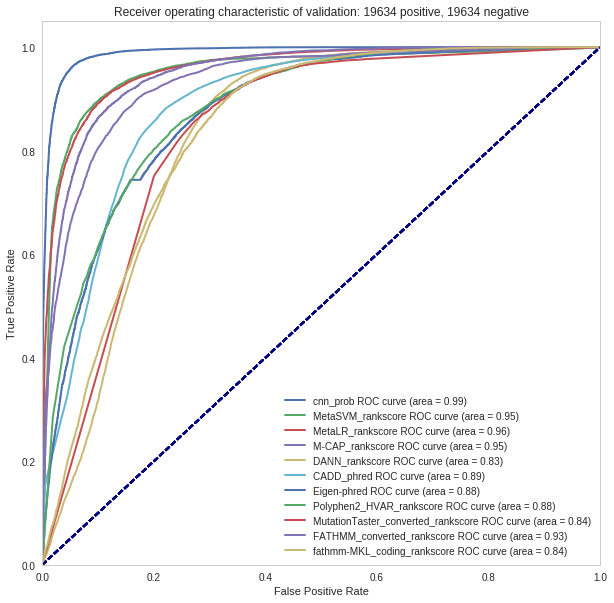

,dist,fpr,threshold,tpr
6344,0.908271,0.054650,0.474027,0.962921
6347,0.908322,0.054752,0.473595,0.963074
6349,0.908373,0.054803,0.472951,0.963176


In [25]:
class_names = ['damage_negative', 'damage_positive']
fname = validation
df = pd.read_csv(fname)
y_true = df.pop('target')
plot_roc(df, y_true, label = 'validation')
Find_Optimal_Cutoff(y_true, df['cnn_prob'])

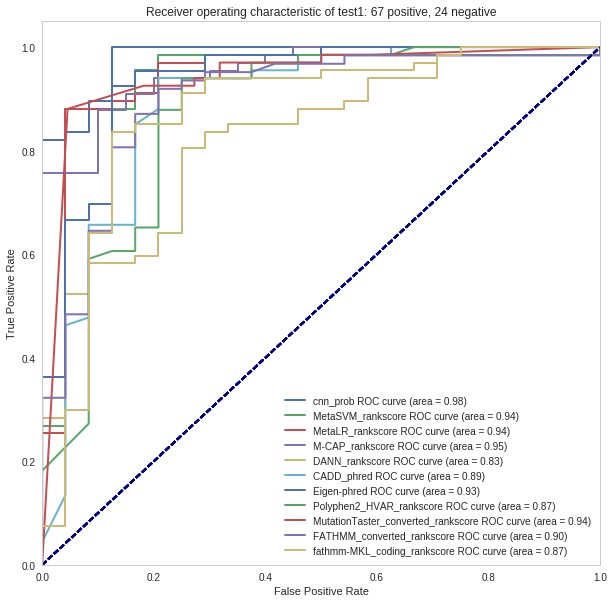

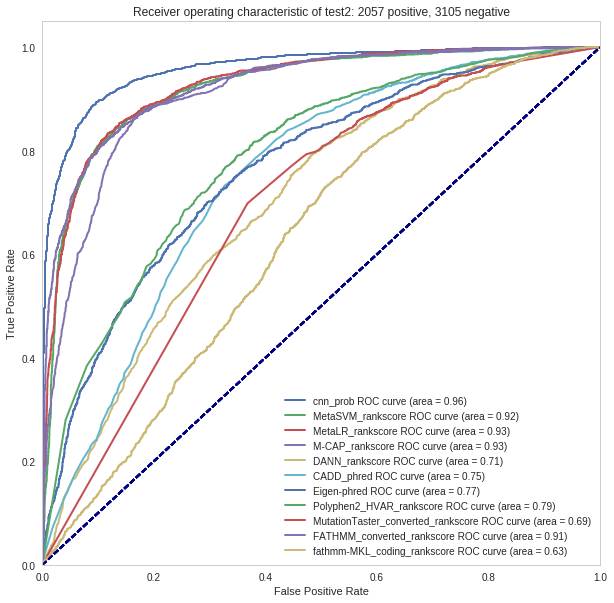

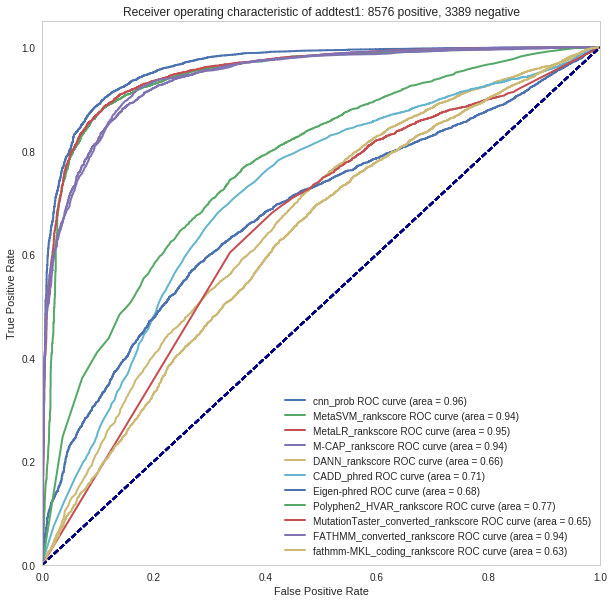

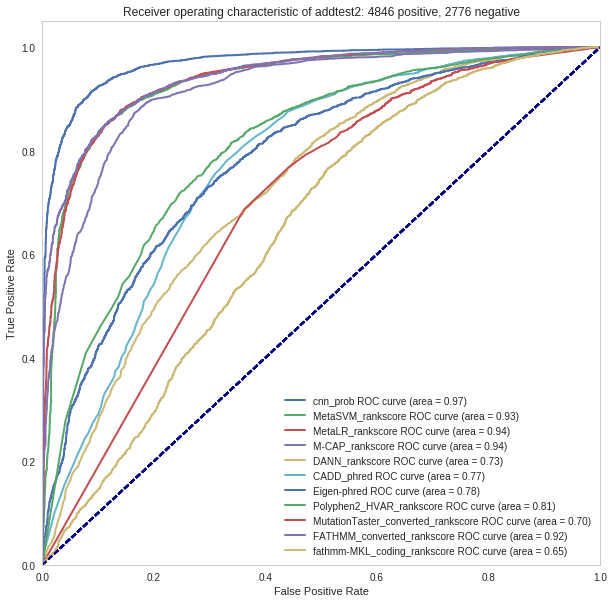

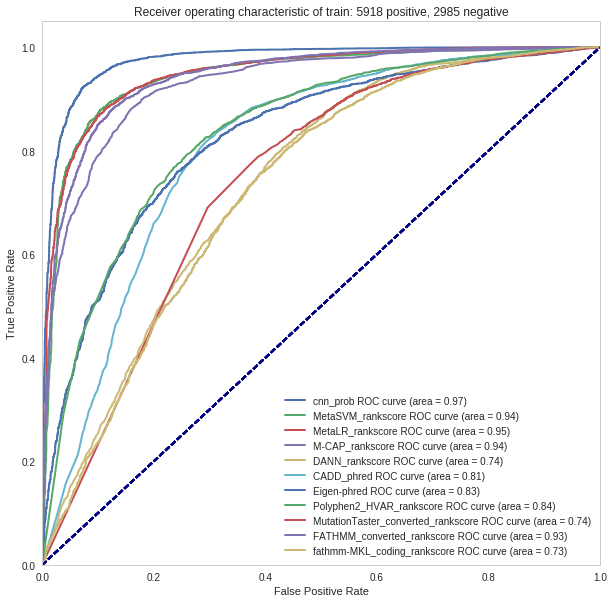

In [26]:
# metaSVM test
fnames = ['../data/metaSVM/metaSVM_test1.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_test2.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest1.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest2.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_train.anno.rare.'+prefix+'reformat.cnn.csv']
labels = []
for fname in fnames:
    labels.append(fname.split('_')[-1].split('.')[0])
    
for fname, lable in zip(fnames, labels):
    df = pd.read_csv(fname)
    y_true = df.pop('category')
    index = y_true == 'TP'
    y_true[index] = 1
    y_true[~index] = 0
    y_true = y_true.astype(int)
    plot_roc(df, y_true, lable)

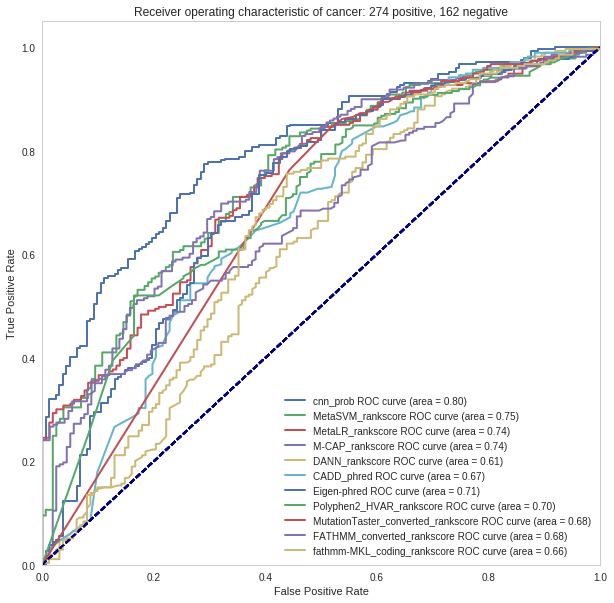

In [27]:
class_names = ['cancer_passengers', 'cancer_hotspot']
fname = '../data/cancer_hotspots/cancer.'+prefix+'reformat.cnn.csv'
df = pd.read_csv(fname)
y_true = df.pop('target')
plot_roc(df, y_true, label = 'cancer')

# enrichment

In [30]:
fname = '../data/gene/gene_mutation_rate0520.txt'
mutation_bkgrd = MutationBackground(fname)

def display_enrichment(case_info, control_info, case_disease, geneset, sort_key='Col'):
    
    print case_disease
    df_case, case_disease, disease_size = case_info 
    df_control, control_disease, disease_size = control_info 
    case_size = 0.0
    for disease in case_disease:
        if disease in disease_size:
            case_size += disease_size[disease]
    control_size = 0.0
    for disease in control_disease:
        control_size += disease_size[disease]
    print 'case size:{} control size:{}'.format(case_size, control_size)
    
    # add PDmis columns
    df_case['PDmis'] = np.where((df_case['CADD_phred'] >= 15) & (df_case['Polyphen2_HDIV_rankscore'] >= 0.52875) , 1, 0)
    df_control['PDmis'] = np.where((df_control['CADD_phred'] >= 15) & (df_control['Polyphen2_HDIV_rankscore'] >= 0.52875) , 1, 0)
    # 'M-CAP_rankscore', 0.4815 is 0.025 cutoff 0.642 is 0.05 cutoff
    col_dict={'cadd15':('CADD_phred', 15), 'cadd20':('CADD_phred', 20),
              'cadd25':('CADD_phred', 25), 'cadd30':('CADD_phred', 30),
              'eigen_pred10':('Eigen-phred', 10), 'eigen_pred15':('Eigen-phred', 15),
              'eigen_pc_pred10':('Eigen-PC-phred', 10), 
              'MetaSVM>0':('MetaSVM_rankscore', 0.82271),'MetaLR>0':('MetaLR_rankscore', 0.81122), 
              'M_CAP>0.025':('M-CAP_rankscore', 0.4815), 'M_CAP>0.05':('M-CAP_rankscore', 0.642), 
              'PP2-HVAR':('Polyphen2_HVAR_rankscore', 0.6280),'FATHMM':('FATHMM_converted_rankscore', 0.8235),
              'all_missense':('cnn_prob', 0.0),'cnn_0.05':('cnn_prob', 0.05),
              'cnn_0.1':('cnn_prob', 0.1), 'cnn_0.2':('cnn_prob', 0.2),
              'cnn_0.3':('cnn_prob', 0.3), 'cnn_0.4':('cnn_prob', 0.4),
              'cnn_0.5':('cnn_prob', 0.5), 'cnn_0.6':('cnn_prob', 0.6),
              'cnn_0.7':('cnn_prob', 0.7), 'cnn_0.8':('cnn_prob', 0.8),
              'cnn_best_0.56':('cnn_prob', 0.56)}

    
    infos = [] 
    for col_name, (col, threshold) in col_dict.items():
        case_count = np.sum(convert2binary(df_case, col, threshold))
        control_count = np.sum(convert2binary(df_control, col, threshold))
        total_counts = case_count + control_count
        control_count = max(control_count, 1)
        enrich = float(case_count) / case_size / (float(control_count) / control_size)
        pvalue = scipy.stats.binom_test(case_count, total_counts,
                                            case_size / (case_size + control_size))
        risk_gene = case_count * (enrich - 1) / enrich
        enrich = max(enrich, 1)
        tpr = (enrich - 1) / enrich
        
        exp = mutation_bkgrd.expectation(geneset, col_name) * case_size
        exp_enr = case_count / exp
        exp_risk_gene = case_count * (exp_enr - 1) / exp_enr
        exp_tpr = (exp_enr - 1) / exp_enr
        
        
        infos.append([col_name, case_count, control_count, 
                      enrich, pvalue, risk_gene, tpr,
                      exp, exp_enr, exp_risk_gene, exp_tpr])
        
    
    labels = ['Col', 'Case', 'Control', 'enrich', 'pvalue', '# risk gene', 'true positive rate',
              'exp', 'exp_enr', 'exp_risk_gene', 'exp_tpr']            
    df = pd.DataFrame(infos,columns=labels)
    df = df.sort_values(by=sort_key, ascending=True)
    display(df)
    plot_rate_vs_riskvariants(df, title=','.join(case_disease))
    return df

def plot_rate_vs_riskvariants(df, title):
    x = list(df['true positive rate'])
    y = list(df['# risk gene'])
    
#     x = list(df['exp_tpr'])
#     y = list(df['exp_risk_gene'])
    methods = list(df['Col'])
    fig, ax = plt.subplots(figsize = (15,10))
    ax.scatter(x, y, s=100)
    for i, txt in enumerate(methods):
        if 'cnn' in txt:
            color = 'red'
        elif 'all_missense' in txt:
            color = 'blue'
        else:
            color = 'black'
        ax.annotate(txt, (x[i],y[i]), fontsize=15, color=color)
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_xlabel('true positive rate', fontsize=15)
    ax.set_ylabel('# risk gene', fontsize=15)
    
    case_variants, control_variants = df.ix[df['Col']=='all_missense'][['Case', 'Control']].values[0]
    
    ax.set_title('{}: {} variants in cases, {} variants in controls'.format(title, 
                                            case_variants, control_variants), fontsize=15)  

['ASD']
case size:3953.0 control size:1911.0


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate,exp,exp_enr,exp_risk_gene,exp_tpr
4,FATHMM,224.0,60.0,1.804806,2.656845e-05,99.886970,0.445924,174.222769,1.285710,49.777231,0.222220
21,M_CAP>0.025,651.0,232.0,1.356522,4.881681e-05,171.096285,0.262821,926.039938,0.702993,-275.039938,-0.422488
17,M_CAP>0.05,451.0,159.0,1.371239,5.383392e-04,122.100471,0.270733,418.840117,1.076783,32.159883,0.071308
20,MetaLR>0,286.0,89.0,1.553495,2.136897e-04,101.899006,0.356290,213.188756,1.341534,72.811244,0.254585
18,MetaSVM>0,284.0,86.0,1.596444,9.809073e-05,106.104657,0.373608,205.185455,1.384114,78.814545,0.277516
1,PP2-HVAR,495.0,166.0,1.441554,3.210395e-05,151.620617,0.306304,381.815145,1.296439,113.184855,0.228656
0,all_missense,1187.0,425.0,1.350192,6.579291e-08,307.866039,0.259365,950.242745,1.249154,236.757255,0.199459
19,cadd15,1027.0,360.0,1.379119,8.128087e-08,282.321821,0.274900,771.552330,1.331083,255.447670,0.248732
6,cadd20,934.0,327.0,1.380807,3.119312e-07,257.583987,0.275786,688.526370,1.356520,245.473630,0.262820
11,cadd25,627.0,194.0,1.562427,2.111608e-08,225.701204,0.359970,405.946762,1.544538,221.053238,0.352557


['DDD_new']
case size:4293.0 control size:1911.0


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate,exp,exp_enr,exp_risk_gene,exp_tpr
4,FATHMM,507.0,60.0,3.761461,2.800239e-30,372.211931,0.734146,189.207778,2.679594,317.792222,0.626809
21,M_CAP>0.025,1236.0,232.0,2.371539,8.008920e-40,714.819466,0.578333,1005.689212,1.229008,230.310788,0.186336
17,M_CAP>0.05,1003.0,159.0,2.808042,5.292128e-42,645.811617,0.643880,454.864818,2.205051,548.135182,0.546496
20,MetaLR>0,650.0,89.0,3.251046,4.825161e-33,450.064364,0.692407,231.525254,2.807469,418.474746,0.643807
18,MetaSVM>0,664.0,86.0,3.436920,7.119860e-36,470.803768,0.709042,222.833584,2.979802,441.166416,0.664407
1,PP2-HVAR,1013.0,166.0,2.716446,1.365846e-40,640.086342,0.631872,414.655304,2.442993,598.344696,0.590666
0,all_missense,2037.0,425.0,2.133545,4.882309e-53,1082.251177,0.531297,1031.973717,1.973887,1005.026283,0.493386
19,cadd15,1819.0,360.0,2.249210,1.048995e-52,1010.271586,0.555399,837.914029,2.170867,981.085971,0.539355
6,cadd20,1725.0,327.0,2.348233,5.370875e-54,990.405024,0.574148,747.746953,2.306930,977.253047,0.566524
11,cadd25,1295.0,194.0,2.971446,7.056049e-58,859.185243,0.663464,440.862496,2.937424,854.137504,0.659566


['CHD_yale']
case size:2645.0 control size:1911.0


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate,exp,exp_enr,exp_risk_gene,exp_tpr
4,FATHMM,170.0,60.0,2.047070,6.356714e-07,86.954474,0.511497,116.574557,1.458294,53.425443,0.314267
21,M_CAP>0.025,464.0,232.0,1.444991,3.831976e-06,142.890633,0.307954,619.624497,0.748841,-155.624497,-0.335398
17,M_CAP>0.05,341.0,159.0,1.549502,3.538684e-06,120.929356,0.354632,280.250977,1.216767,60.749023,0.178150
20,MetaLR>0,215.0,89.0,1.745354,6.820734e-06,91.815803,0.427050,142.647169,1.507215,72.352831,0.336525
18,MetaSVM>0,212.0,86.0,1.781035,3.212638e-06,92.968080,0.438529,137.292064,1.544153,74.707936,0.352396
1,PP2-HVAR,324.0,166.0,1.410171,2.909787e-04,94.240712,0.290866,255.477121,1.268215,68.522879,0.211490
0,all_missense,817.0,425.0,1.388891,2.704994e-08,228.760858,0.280001,635.818887,1.284957,181.181113,0.221764
19,cadd15,695.0,360.0,1.394817,2.124644e-07,196.726845,0.283060,516.254974,1.346234,178.745026,0.257187
6,cadd20,633.0,327.0,1.398592,6.337497e-07,180.401884,0.284995,460.701302,1.373992,172.298698,0.272194
11,cadd25,384.0,194.0,1.430094,4.182663e-05,115.486133,0.300745,271.623877,1.413720,112.376123,0.292646


['SSC_yale']
case size:1789.0 control size:1911.0


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate,exp,exp_enr,exp_risk_gene,exp_tpr
4,FATHMM,68.0,60.0,1.210620,0.289628,11.830455,0.173977,78.847593,0.862423,-10.847593,-0.159523
21,M_CAP>0.025,252.0,232.0,1.160280,0.111341,34.811094,0.138139,419.095737,0.601295,-167.095737,-0.663078
17,M_CAP>0.05,180.0,159.0,1.209277,0.082197,31.150706,0.173059,189.553496,0.949600,-9.553496,-0.053075
20,MetaLR>0,88.0,89.0,1.056192,0.763660,4.681842,0.053203,96.482339,0.912084,-8.482339,-0.096390
18,MetaSVM>0,86.0,86.0,1.068195,0.703057,5.490319,0.063841,92.860303,0.926122,-6.860303,-0.079771
1,PP2-HVAR,175.0,166.0,1.126109,0.278881,19.597593,0.111986,172.797190,1.012748,2.202810,0.012587
0,all_missense,454.0,425.0,1.141083,0.054342,56.132391,0.123640,430.049145,1.055693,23.950855,0.052755
19,cadd15,378.0,360.0,1.121604,0.121943,40.982732,0.108420,349.179641,1.082537,28.820359,0.076244
6,cadd20,339.0,327.0,1.107394,0.200713,32.875981,0.096979,311.604775,1.087917,27.395225,0.080812
11,cadd25,205.0,194.0,1.128762,0.229658,23.385139,0.114074,183.718380,1.115838,21.281620,0.103813


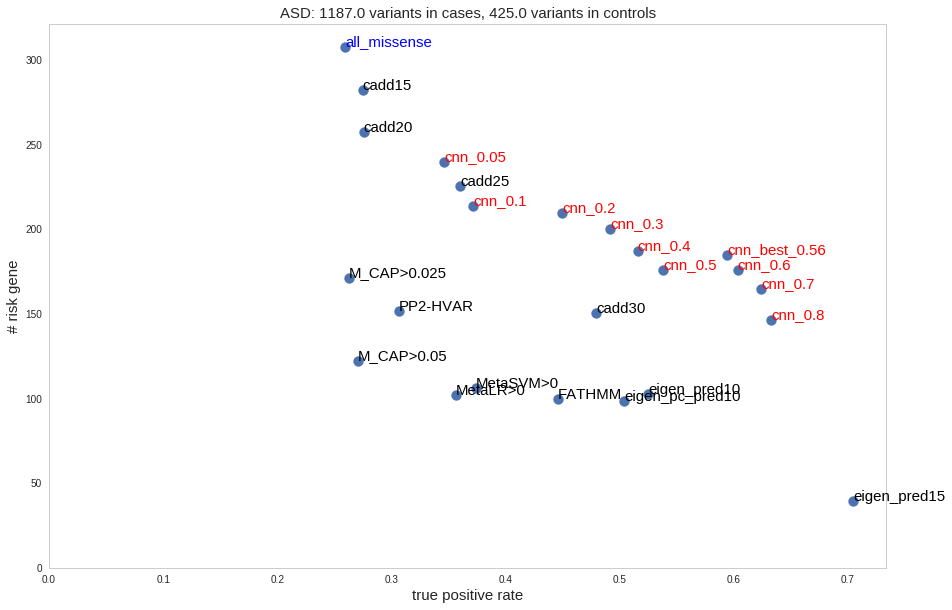

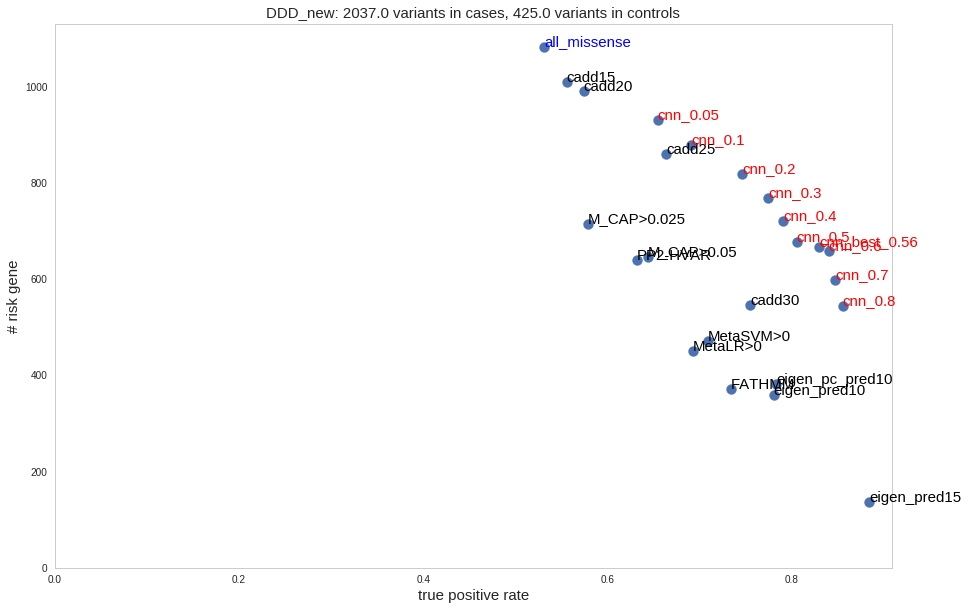

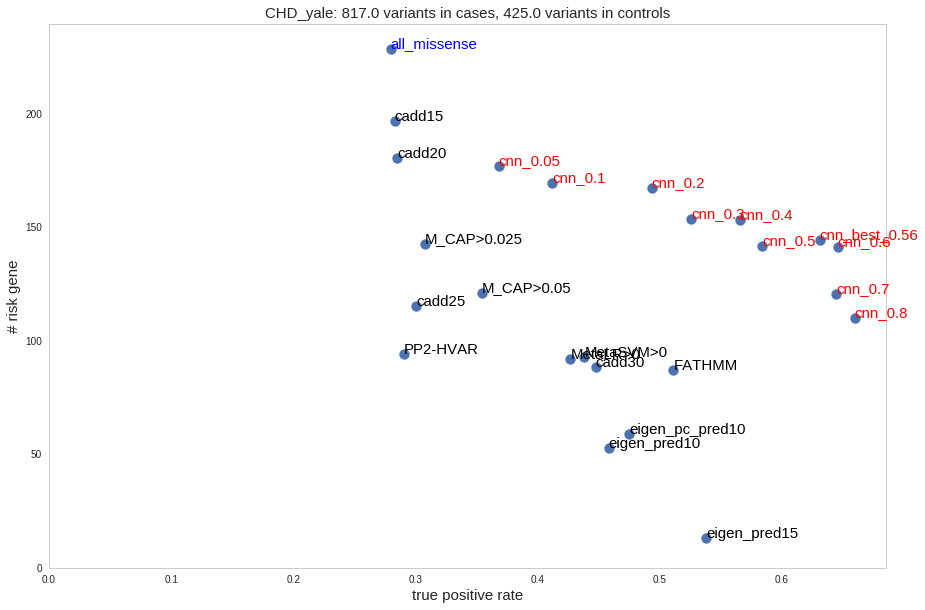

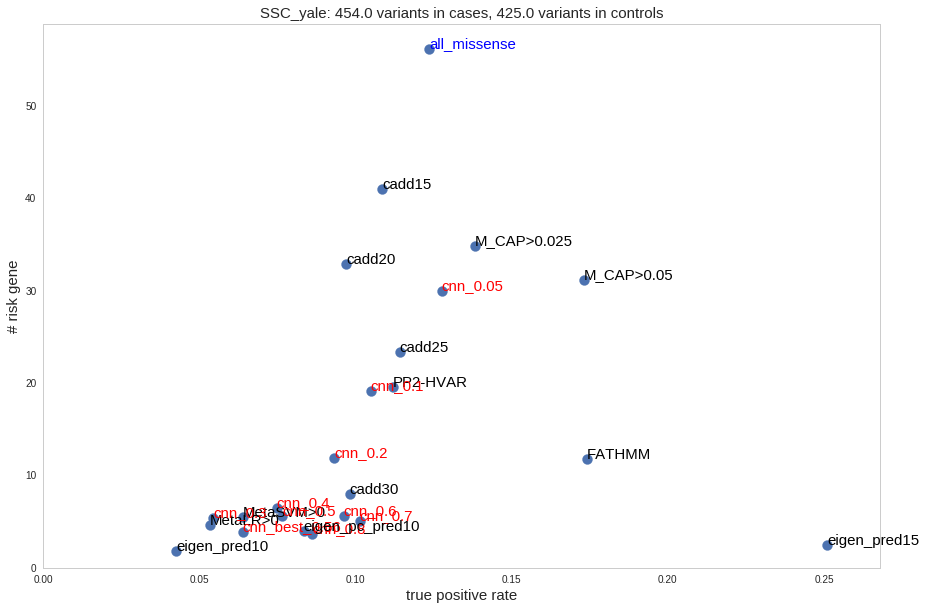

In [31]:


disease_size = {'CHD':2779, 'CDH':307,'CDH_MGH':80,
                'ASD':3953, 'EE':264, 'ID':192,
                'DDD_new':4293, 'DDD':1133, 'SSC':1911,
                'CHD_yale':2645, 'SSC_yale':1789 } 




fname = '../data/case_control/ssc_yale.anno.rare.'+prefix+'reformat.cnn.csv'
control_disease = ['SSC_yale']

fname = '../data/case_control/control_1911.anno.rare.'+prefix+'reformat.cnn.csv'
control_disease = ['SSC']

df_control = pd.read_csv(fname)
index = df_control['disease'].isin(control_disease) & df_control['genename'].isin(geneset) 
#index = index & (df_control['prec'] >=0.8)

df_control = df_control[index]
control_info = (df_control, control_disease, disease_size)



# data is a little more than ANNOVAR annotatoin, do a comparison later
case_diseases = [['CHD'], ['CDH'], ['ASD'],['EE'], ['ID'], ['DDD'], 
                 ['CHD', 'CDH', 'ASD','EE', 'ID', 'DDD']]

case_diseases = [['ASD']]

for case_disease in case_diseases:

    fname = '../data/case_control/case.anno.rare.'+prefix+'reformat.cnn.csv'
    df_case = pd.read_csv(fname)
    index = df_case['disease'].isin(case_disease) & df_case['genename'].isin(geneset) 
    
    df_case = df_case[index]
    case_info = (df_case, case_disease, disease_size)
    df = display_enrichment(case_info, control_info, case_disease, geneset)

fname = '../data/case_control/DDD_new_0.2.anno.rare.'+prefix+'reformat.cnn.csv'
case_disease = ['DDD_new']
df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment(case_info, control_info, case_disease, geneset)

    
fname = '../data/case_control/chd_yale.anno.rare.'+prefix+'reformat.cnn.csv'
case_disease = ['CHD_yale']
df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment(case_info, control_info, case_disease, geneset)


fname = '../data/case_control/ssc_yale.anno.rare.'+prefix+'reformat.cnn.csv'
case_disease = ['SSC_yale']
df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment(case_info, control_info, case_disease, geneset)

In [9]:
mutation_bkgrd.rate['GATA4']

{'FATHMM': 2.28996826263416e-05,
 'M_CAP>0.025': 2.25534559885444e-05,
 'M_CAP>0.05': 2.23268122485078e-05,
 'MetaLR>0': 2.16112274644191e-05,
 'MetaSVM>0': 2.10965714917765e-05,
 'PP2-HVAR': 8.65859143444515e-06,
 'all_missense': 2.28996826263416e-05,
 'cadd10': 1.95760532586663e-05,
 'cadd15': 1.75420997874314e-05,
 'cadd20': 1.56586872112755e-05,
 'cadd25': 8.70931136225829e-06,
 'cadd30': 4.09290586572245e-06,
 'cadd35': 1.12333770977587e-06,
 'cnn_0.05': 2.21443478105257e-05,
 'cnn_0.1': 2.0493838506545e-05,
 'cnn_0.15': 1.93787089401856e-05,
 'cnn_0.2': 1.74778415551537e-05,
 'cnn_0.25': 1.54711817585873e-05,
 'cnn_0.3': 1.40310160844327e-05,
 'cnn_0.35': 1.27615517806584e-05,
 'cnn_0.4': 1.14410339098158e-05,
 'cnn_0.45': 1.05616204710517e-05,
 'cnn_0.5': 9.4534419434282e-06,
 'cnn_0.55': 8.81342415327763e-06,
 'cnn_0.6': 8.11966184324289e-06,
 'cnn_0.65': 7.34977862749245e-06,
 'cnn_0.7': 6.60709120776176e-06,
 'cnn_0.75': 5.79427259032371e-06,
 'cnn_0.8': 5.35055600008677e-06,